In [1]:
folder = "D:/users/marko/downloads/mirna/analysis"
folder2 = "D:/users/marko/downloads/mirna/models"
folder3 = "D:/users/marko/downloads/mirna/"

In [2]:
model_code = "2fh6vyi6"

# library imports

In [3]:
import numpy as np
import pandas as pd
import sys 
import os 
import io
import wandb
import torch

sys.path.insert(0, folder)
sys.path.insert(0, folder2)
os.chdir(folder)
os.makedirs(f"{folder}/latspaces/{model_code}/", exist_ok=True)


from concepts import *
from utils import *
from model import *
from dataset import *

from tqdm import tqdm

import plotly.graph_objs as go
from ipywidgets import HTML, Image, Layout, interactive, \
                       RadioButtons, HBox, VBox, interact
import PIL.Image
from graphviz import Digraph, Source

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

from scipy.stats import pearsonr, spearmanr, kendalltau


In [4]:
# connect with wandb and access run
api = wandb.Api(api_key='46d1be10d4e9900dd55fb752c4ecaa4ca0341b20')
run = api.run(f"generativemirna/final_experiments_thesis/{model_code}")

In [8]:

class Args:
    
    def __init__(self, args, conv=False):
        if conv:
            setattr(self, 'sttng', 'conv') 
        for i in args:
            setattr(self, i, args[i])

In [9]:
args = Args(run.config, True)
args = process_args(args)

In [10]:
if args.model_type == 'vae':
    model = MIRVAE(args).to('cuda')
elif args.model_type == 'diva':
    model = MIRDIVA(args).to('cuda')

model.load_state_dict(torch.load('D:/users/marko/downloads/mirna/thesis_experiments/diva_iaf/checkpoints/200.pth'))

<All keys matched successfully>

In [11]:
train_loader = get_data_loader(folder3, 'train', analysis=True)
test_loader = get_data_loader(folder3, 'test', analysis=True)

Loading Labels! (~10s)
Loading Names! (~5s)
Loading Labels! (~10s)
Loading Names! (~5s)


In [ ]:
concepts_train = pd.read_csv(f'{folder3}/data/concepts_tr.csv')
concepts_test = pd.read_csv(f'{folder3}/data/concepts_te.csv')

# concepts_train = create_annotated_df(train_loader.dataset.images*255, train_loader.dataset.labels.argmax(1))
# concepts_test = create_annotated_df(test_loader.dataset.images*255, test_loader.dataset.labels.argmax(1))

# concepts_train.to_csv(f'{folder3}/data/concepts_tr.csv')
# concepts_test.to_csv(f'{folder3}/data/concepts_te.csv')

concepts_train['loop_length'].fillna(0, inplace=True)
concepts_train['loop_width'].fillna(0, inplace=True)
concepts_train.replace(['upper','lower'], [1,-1], inplace=True)
concepts_train.fillna(-1, inplace=True)

concepts_test['loop_length'].fillna(0, inplace=True)
concepts_test['loop_width'].fillna(0, inplace=True)
concepts_test.replace(['upper','lower'], [1,-1], inplace=True)
concepts_test.fillna(-1, inplace=True)

In [ ]:
z_tr, x_hat_tr, x_tr = model_analysis(model, args, train_loader)
z_te, x_hat_te, x_te = model_analysis(model, args, test_loader)

In [11]:
latent_space_m = TSNE().fit_transform(z_te['m'])

In [12]:
fig = go.FigureWidget(
    data=[
        dict(
            type='scattergl',
            x=latent_space_m[:,0],
            y=latent_space_m[:,1],
            mode='markers',
            marker = dict(color=np.argmax(test_loader.dataset.labels,1),
                          size=4),
          
        )
    ],
    
    layout=dict(height=500, width=750)
)

In [13]:
def set_color(column):
    fig.data[0].marker.color = concepts_test[column]*1

In [14]:
radio = RadioButtons(options=concepts_test.columns[2:])
radiowidget = interact(set_color, column=radio)

interactive(children=(RadioButtons(description='column', options=('class_label', 'presence_terminal_loop', 'st…

In [15]:
def compress_to_bytes(data, fmt):
    """
    Helper function to compress image data via PIL/Pillow.
    """
    data = data.repeat(10, axis=0).repeat(10, axis=1)
    buff = io.BytesIO()
    img = PIL.Image.fromarray(np.uint8(data*255))    
    img.save(buff, format=fmt)
    
    return buff.getvalue()

def hover_fn(trace, points, state):

    ind = points.point_inds[0]

    
    # Update image widget
    im = compress_to_bytes(test_loader.dataset.images[ind],'png')
    image_widget.value = im
    details.value = pd.DataFrame({'name':[test_loader.dataset.names[ind]], 'class':[test_loader.dataset.labels.argmax(1)[ind]]}).to_html(col_space={'name':250,'class':50})
    
details = HTML()
details.value = pd.DataFrame({'name':[test_loader.dataset.names[0]], 'class':[test_loader.dataset.labels.argmax(1)[0]]}).to_html(col_space={'name':250,'class':50})

In [16]:
fig.data[0].on_hover(hover_fn)

In [17]:
fmt='png'
im = compress_to_bytes(test_loader.dataset.images[0],fmt)
image_widget = Image(
    value=im,
    layout=Layout(height='250px', width='1000px')
)

In [18]:
VBox([HBox([fig, 
      radio]), HBox([image_widget]), details])

    'data': [{'marker': {'color': array([0, 0, 1, ..., 1, 0, 0], …

In [19]:
from decisiontree import Tree

In [20]:

thresholds = {'start_loop_upperhalf_col':[3,7,15,30,45],
              'highest_point_loop_upperhalf_col':[3,7,9,15,30,45],
              'gap_start':[2,8,20,40],
              'palindrome_score':[.25,.5,.6,.7,.8,.9],
              'large_asymmetric_bulge':[2,4,8,10,20,40,60],
              'largest_asym_bulge_sequence_location':[5,20,40,60,80],
              'stem_begin':[15,35,45,55,60,75],
              'stem_end':[3,5,8,12,20,30,40],
              'stem_length':[10,20,30,35,40,45,50,55,60,70,80,90],
              'total_length':[20,30,40,50,60,70,80,90],
              'base_pairs_in_stem':[.1,.3,.5,.7,.9],
              'base_pairs_wobbles_in_stem':[.1,.3,.5,.7,.9],
              'loop_width':[2,8,20,45],
              
              }

In [21]:
dtc = Tree(thresholds, max_depth=5, cls=LinearSVC,
           cls_args=dict(dual=False))

In [22]:
dtc.fit(z_tr['m'], train_loader.dataset.labels.argmax(1).flatten(), concepts_train[concepts_train.columns[3:]], prune=True)

In [23]:
dtc.score(z_tr['m'], train_loader.dataset.labels.argmax(1).flatten())

0.9453644768295844

In [24]:
dtc.score(z_te['m'], test_loader.dataset.labels.argmax(1).flatten())

0.9143202741751226

In [25]:
g = dtc.plot_tree()
g.render('dtc_new_', format='png')

'dtc_new_.png'

In [26]:
def plot_latent_space(z, c):
    plt.scatter(z[:,0], z[:,1], c=c, s=.1)

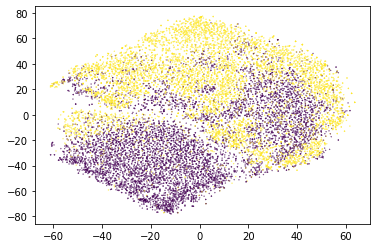

In [27]:
plot_latent_space(latent_space_m,test_loader.dataset.labels.argmax(1).flatten())

In [28]:
def calculate_error_statistics(x, x_hat):
    '''
    function which calculates all reconstruction statistics
    '''
    correct_nt = correct_nucleotides(x, x_hat)
    correct_sh = correct_shape(x, x_hat)
    correct_le = correct_length(x, x_hat)
    return correct_nt, correct_sh, correct_le
    
def correct_nucleotides(x, x_hat):
    '''
    calculates which nucleotides are correct
    '''
    return x[:,:,12:14]==x_hat[:,:,12:14]

def correct_shape(x, x_hat):
    '''
    calculates how correct the shape is
    '''
    x, x_hat = x.sum((1,2)), x_hat.sum((1,2))
    return x == x_hat

def correct_length(x, x_hat):
    '''
    calculates which part of the length of the reconstruction is correct
    '''
    x, x_hat = x[:,:,12:13].sum(1), x_hat[:,:,12:13].sum(1) 
    return x == x_hat

In [29]:
nt, sh, le = calculate_error_statistics(test_loader.dataset.images_cat, x_hat_te)

In [30]:
nt.mean()

0.9957745447214569

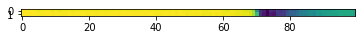

In [31]:
plt.imshow(nt.prod(axis=1).mean(0))

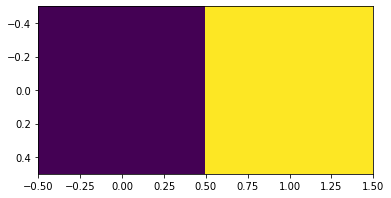

In [32]:
plt.imshow([[0,1]])

In [ ]:
nt.mean()

In [71]:
np.prod([True,False])

0

In [12]:
err = 1 - (x_te ==  x_hat_te).prod(1)

In [13]:
err.max()

1

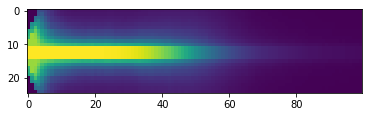

In [22]:
plt.imshow(x_te.sum(1).mean(0))

In [30]:
err.sum(0).max()

917

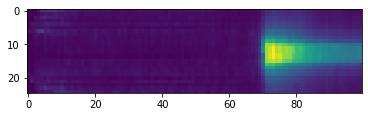

In [29]:
plt.imshow(err.sum(0))

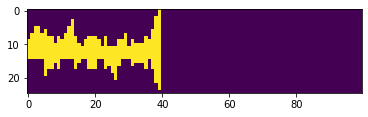

In [16]:
plt.imshow(x_te[1].sum(0))

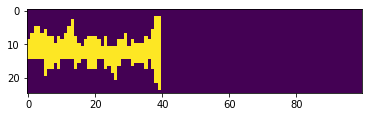

In [17]:
plt.imshow(x_hat_te[1].sum(0))

In [32]:
torch.nn.functional.one_hot(torch.tensor([[1,2,3,4]])).argmax(2)

tensor([[1, 2, 3, 4]])

In [39]:
concepts_test[concepts_test.columns[3:]]['presence_terminal_loop']*1.0

0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
14876    1.0
14877    0.0
14878    1.0
14879    0.0
14880    0.0
Name: presence_terminal_loop, Length: 14881, dtype: float64

In [42]:
np.corrcoef([1,2,3],[2,3,4])

array([[1., 1.],
       [1., 1.]])

In [45]:
z_tr['m'].shape

(34721, 64)

In [61]:
def get_top_cor(col, z, top = 4):
    cor = np.zeros((z.shape[1],))
    
    for i in range(z.shape[1]):
        cor[i] = spearmanr(z[:,i], col)[0]
    
    cor_abs = np.abs(cor)
    idx = np.argsort(cor_abs)[::-1][:top]
    
    return cor[idx], idx

In [62]:
for i in concepts_test.columns[3:]:
    c, idx = get_top_cor(concepts_test[i]*1.0, zm)
    print(f'{i}: {c} {idx}')

presence_terminal_loop: [-0.54687578 -0.50568814 -0.45718716  0.45261115] [15 10  9 34]
start_loop_upperhalf_col: [-0.65116231 -0.52158547 -0.50579834 -0.4633974 ] [27 39 10 21]
highest_point_loop_upperhalf_row: [-0.6620911  -0.50639063 -0.48075549  0.47229618] [15 17 42 35]
highest_point_loop_upperhalf_col: [-0.64572885 -0.52348993 -0.50901481 -0.46551387] [27 39 10 21]
loop_length: [-0.64187847 -0.51660843 -0.50713847 -0.41934945] [27 10 39 21]
loop_width: [-0.65116231 -0.52158547 -0.50579834 -0.4633974 ] [27 39 10 21]
gap_start: [ 0.56781736  0.48840642  0.45208274 -0.4488866 ] [15 10  9 34]
palindrome_score: [-0.63248715 -0.62971146  0.56356037  0.52986915] [10  9 34 51]
asymmetric: [ 0.46174392  0.45604996  0.43211848 -0.41560638] [ 9 15 10 34]
large_asymmetric_bulge: [ 0.46340681  0.45254556  0.43460824 -0.39885986] [ 9 15 10 34]
largest_asym_bulge_strand_location: [ 0.25868761  0.25235021  0.24705214 -0.23442684] [15  9 10 34]
largest_asym_bulge_sequence_location: [ 0.32660371  

In [53]:
zm = z_te['m']
for i in range(z_te['m'].shape[1]):
    print(f'{i} {pearsonr(zm[:,i], concepts_test[concepts_test.columns[3:]].presence_terminal_loop*1.0)[0]}')

0 0.14011964418587936
1 -0.027015324318706783
2 0.1991583660723179
3 -0.1049297130229704
4 0.19832440820562253
5 0.13287836359825936
6 0.23466439947330586
7 0.06334974325076338
8 0.11674723201531483
9 -0.4452833409510196
10 -0.49608752979514387
11 -0.36696632878720475
12 0.05617992704115656
13 -0.21357974586073614
14 -0.059297594591091296
15 -0.5293271054006033
16 -0.10842481273624902
17 -0.14224310932137238
18 -0.033417921989922314
19 -0.014186637399854735
20 0.004550212165171738
21 -0.24378098776032134
22 0.054195609586182504
23 -0.33691611951137923
24 0.1258934180680727
25 0.2398785066049379
26 0.07796792355533294
27 -0.4389409531723619
28 0.030841717516145298
29 0.12956302422331903
30 0.003635947117515877
31 0.0809915116192387
32 0.14813465536844542
33 -0.0004301033636026912
34 0.4520972377860495
35 0.3125245503842604
36 0.04955017393051441
37 0.19405270375429307
38 0.13333841816924402
39 -0.30401115862723893
40 0.08990965571294034
41 0.1646053626676956
42 -0.254237682789763
43 0.0

In [51]:
zm[:,i].shape, (concepts_test[concepts_test.columns[3:]].presence_terminal_loop*1.0).shape

((34721,), (14881,))